### Plot Experiment Kmer distributions

* We cat all event files from each snoRNA KO experiment then we used grep to isolate kmers 

```
grep BcGGT 20210825_R941_mutant448.tsv > kmer_events/acGGT_mutant448_YPD.events.tsv
grep cBcGG 20210825_R941_mutant448.tsv > kmer_events/cacGG_mutant448_YPD.events.tsv
grep TcBcG 20210825_R941_mutant448.tsv > kmer_events/TcacG_mutant448_YPD.events.tsv
grep GTcBc 20210825_R941_mutant448.tsv > kmer_events/GTcac_mutant448_YPD.events.tsv
grep AGTcB 20210825_R941_mutant448.tsv > kmer_events/AGTca_mutant448_YPD.events.tsv

grep BTAAA 20210825_R941_mutant448.tsv > kmer_events/aTAAA_mutant448_YPD.events.tsv
grep ABTAA 20210825_R941_mutant448.tsv > kmer_events/AaTAA_mutant448_YPD.events.tsv
grep GABTA 20210825_R941_mutant448.tsv > kmer_events/GAaTA_mutant448_YPD.events.tsv
grep AGABT 20210825_R941_mutant448.tsv > kmer_events/AGAaT_mutant448_YPD.events.tsv
grep GAGAB 20210825_R941_mutant448.tsv > kmer_events/GAGAa_mutant448_YPD.events.tsv

grep BTcGc 20210415_R941_mutant451.tsv > kmer_events/aTcGc_mutant451_YPD.events.tsv
grep GBTcG 20210415_R941_mutant451.tsv > kmer_events/GaTcG_mutant451_YPD.events.tsv
grep AGBTc 20210415_R941_mutant451.tsv > kmer_events/AGaTc_mutant451_YPD.events.tsv
grep GAGBT 20210415_R941_mutant451.tsv > kmer_events/GAGaT_mutant451_YPD.events.tsv
grep GGAGB 20210415_R941_mutant451.tsv > kmer_events/GGAGa_mutant451_YPD.events.tsv

grep BTGAT 20210415_R941_mutant451.tsv > kmer_events/aTGAT_mutant451_YPD.events.tsv
grep GBTGA 20210415_R941_mutant451.tsv > kmer_events/GaTGA_mutant451_YPD.events.tsv
grep GGBTG 20210415_R941_mutant451.tsv > kmer_events/GGaTG_mutant451_YPD.events.tsv
grep TGGBT 20210415_R941_mutant451.tsv > kmer_events/TGGaT_mutant451_YPD.events.tsv
grep GTGGB 20210415_R941_mutant451.tsv > kmer_events/GTGGa_mutant451_YPD.events.tsv

grep BCGCG 20210413_R941_mutant452.tsv > kmer_events/aCGCG_mutant452_YPD.events.tsv
grep ABCGC 20210413_R941_mutant452.tsv > kmer_events/AaCGC_mutant452_YPD.events.tsv
grep AABCG 20210413_R941_mutant452.tsv > kmer_events/AAaCG_mutant452_YPD.events.tsv
grep TAABC 20210413_R941_mutant452.tsv > kmer_events/TAAaC_mutant452_YPD.events.tsv
grep TTAAB 20210413_R941_mutant452.tsv > kmer_events/TTAAa_mutant452_YPD.events.tsv
```


In [2]:
import os
from signalalign.hiddenMarkovModel import HmmModel, parse_alignment_file
from signalalign.train.trainModels import parse_assignment_file
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np
import pandas as pd
from scipy.stats import norm, invgauss, entropy
from scipy.spatial.distance import euclidean
from sklearn.neighbors import KernelDensity
import pathlib
from py3helpers.seq_tools import ReferenceHandler
from pathlib import Path


In [11]:
model = "../testing/yeast_rrna_ivt_wt_trained_071521.model"
output_dir = "figures/experiment_kmer_distributions"
reference = "../training/reference/yeast_25S_18S.fa"
rh = ReferenceHandler(reference)
model_handle = HmmModel(model, rna=True)
Path(output_dir).mkdir(parents=True, exist_ok=True)

events_data_path = "figures/experiment_kmer_distributions/kmer_events"
mutant_448 = os.path.join(events_data_path, "{kmer}_mutant448_YPD.events.tsv")
mutant_451 = os.path.join(events_data_path, "{kmer}_mutant451_YPD.events.tsv")
mutant_452 = os.path.join(events_data_path, "{kmer}_mutant452_YPD.events.tsv")


In [12]:
def plot_distributions(panel1, model_handle, kmer_list, data, name, title=None, savefig_dir=None):
    panel1.set_xlabel('pA')
    panel1.set_ylabel('Density')
    panel1.grid(color='black', linestyle='-', linewidth=1, alpha=0.5)
    panel1.xaxis.set_major_locator(ticker.AutoLocator())
    panel1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    min_x = 1000
    max_x = 0

    for kmer in kmer_list:
        normal_mean, normal_sd = model_handle.get_event_mean_gaussian_parameters(kmer)

        tmp_min_x = normal_mean - (5 * normal_sd)
        tmp_max_x = normal_mean + (5 * normal_sd)
        if min_x > tmp_min_x:
            min_x = tmp_min_x
        if max_x < tmp_max_x:
            max_x = tmp_max_x

        # plot ont normal distribution
        x = np.linspace(normal_mean - 4 * normal_sd, normal_mean + 4 * normal_sd, 200)
        ont_handle, = panel1.plot(x, norm.pdf(x, normal_mean, normal_sd), label=f"{kmer[::-1]} Model Distribution")


    kmer_assignments = data
    kmer_data = kmer_assignments["level_mean"]
    # get event means and linspace in correct format
    x = np.asarray(kmer_data).reshape(len(kmer_data), 1)
    x_plot = model_handle.linspace[:, np.newaxis]
    # get estimate for data
    kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(x)
    # estimate across the linspace
    log_dens = kde.score_samples(x_plot)
    kde_handle, = panel1.plot(x_plot[:, 0], np.exp(log_dens),
                              '-', label=f"KDE Events from {name}")

    # create legend
#     panel1.legend(loc='upper left', bbox_to_anchor=(1, 0.2))
    panel1.legend()
    panel1.set_xlim(min_x, max_x)
    if title is not None:
        panel1.set_title(title)
    else:
        panel1.set_title(f"{name} KO: {kmer} / {kmer}")

    # option to save figure or just show it


In [13]:
experiments = []
# snr80 
name = "snr80"
event_path = mutant_448

# 18S 759
kmers = ["aTAAA", "AaTAA", "GAaTA", "AGAaT", "GAGAa"]
seq = rh.get_sequence("RDN18-1", 759-5, 759+4).replace("T", "U")
experiments.append([name, kmers, mutant_448, "RDN18-1", 759])
# 25S 776
kmers = ["acGGT", "cacGG", "TcacG", "GTcac", "AGTca"]
seq = rh.get_sequence("RDN25-1", 776-5, 776+4).replace("T", "U")
experiments.append([name, kmers, mutant_448, "RDN25-1", 776])

In [14]:
# snr83
name = "snr83"
event_path = mutant_451

# 18S 1290
kmers = ["aTGAT", "GaTGA", "GGaTG", "TGGaT", "GTGGa"]
seq = rh.get_sequence("RDN18-1", 1289-5, 1289+4).replace("T", "U")
experiments.append([name, kmers, mutant_451, "RDN18-1", 1290])
# 18S 1415
kmers = ["aTcGc", "GaTcG", "AGaTc", "GAGaT", "GGAGa"]
experiments.append([name, kmers, mutant_451, "RDN18-1", 1415])

In [15]:
# snr87 
# 18S 436
name = "snr87"
kmers = ["aCGCG", "AaCGC", "AAaCG", "TAAaC", "TTAAa"]
event_path = mutant_452
experiments.append([name, kmers, mutant_452, "RDN18-1", 436])

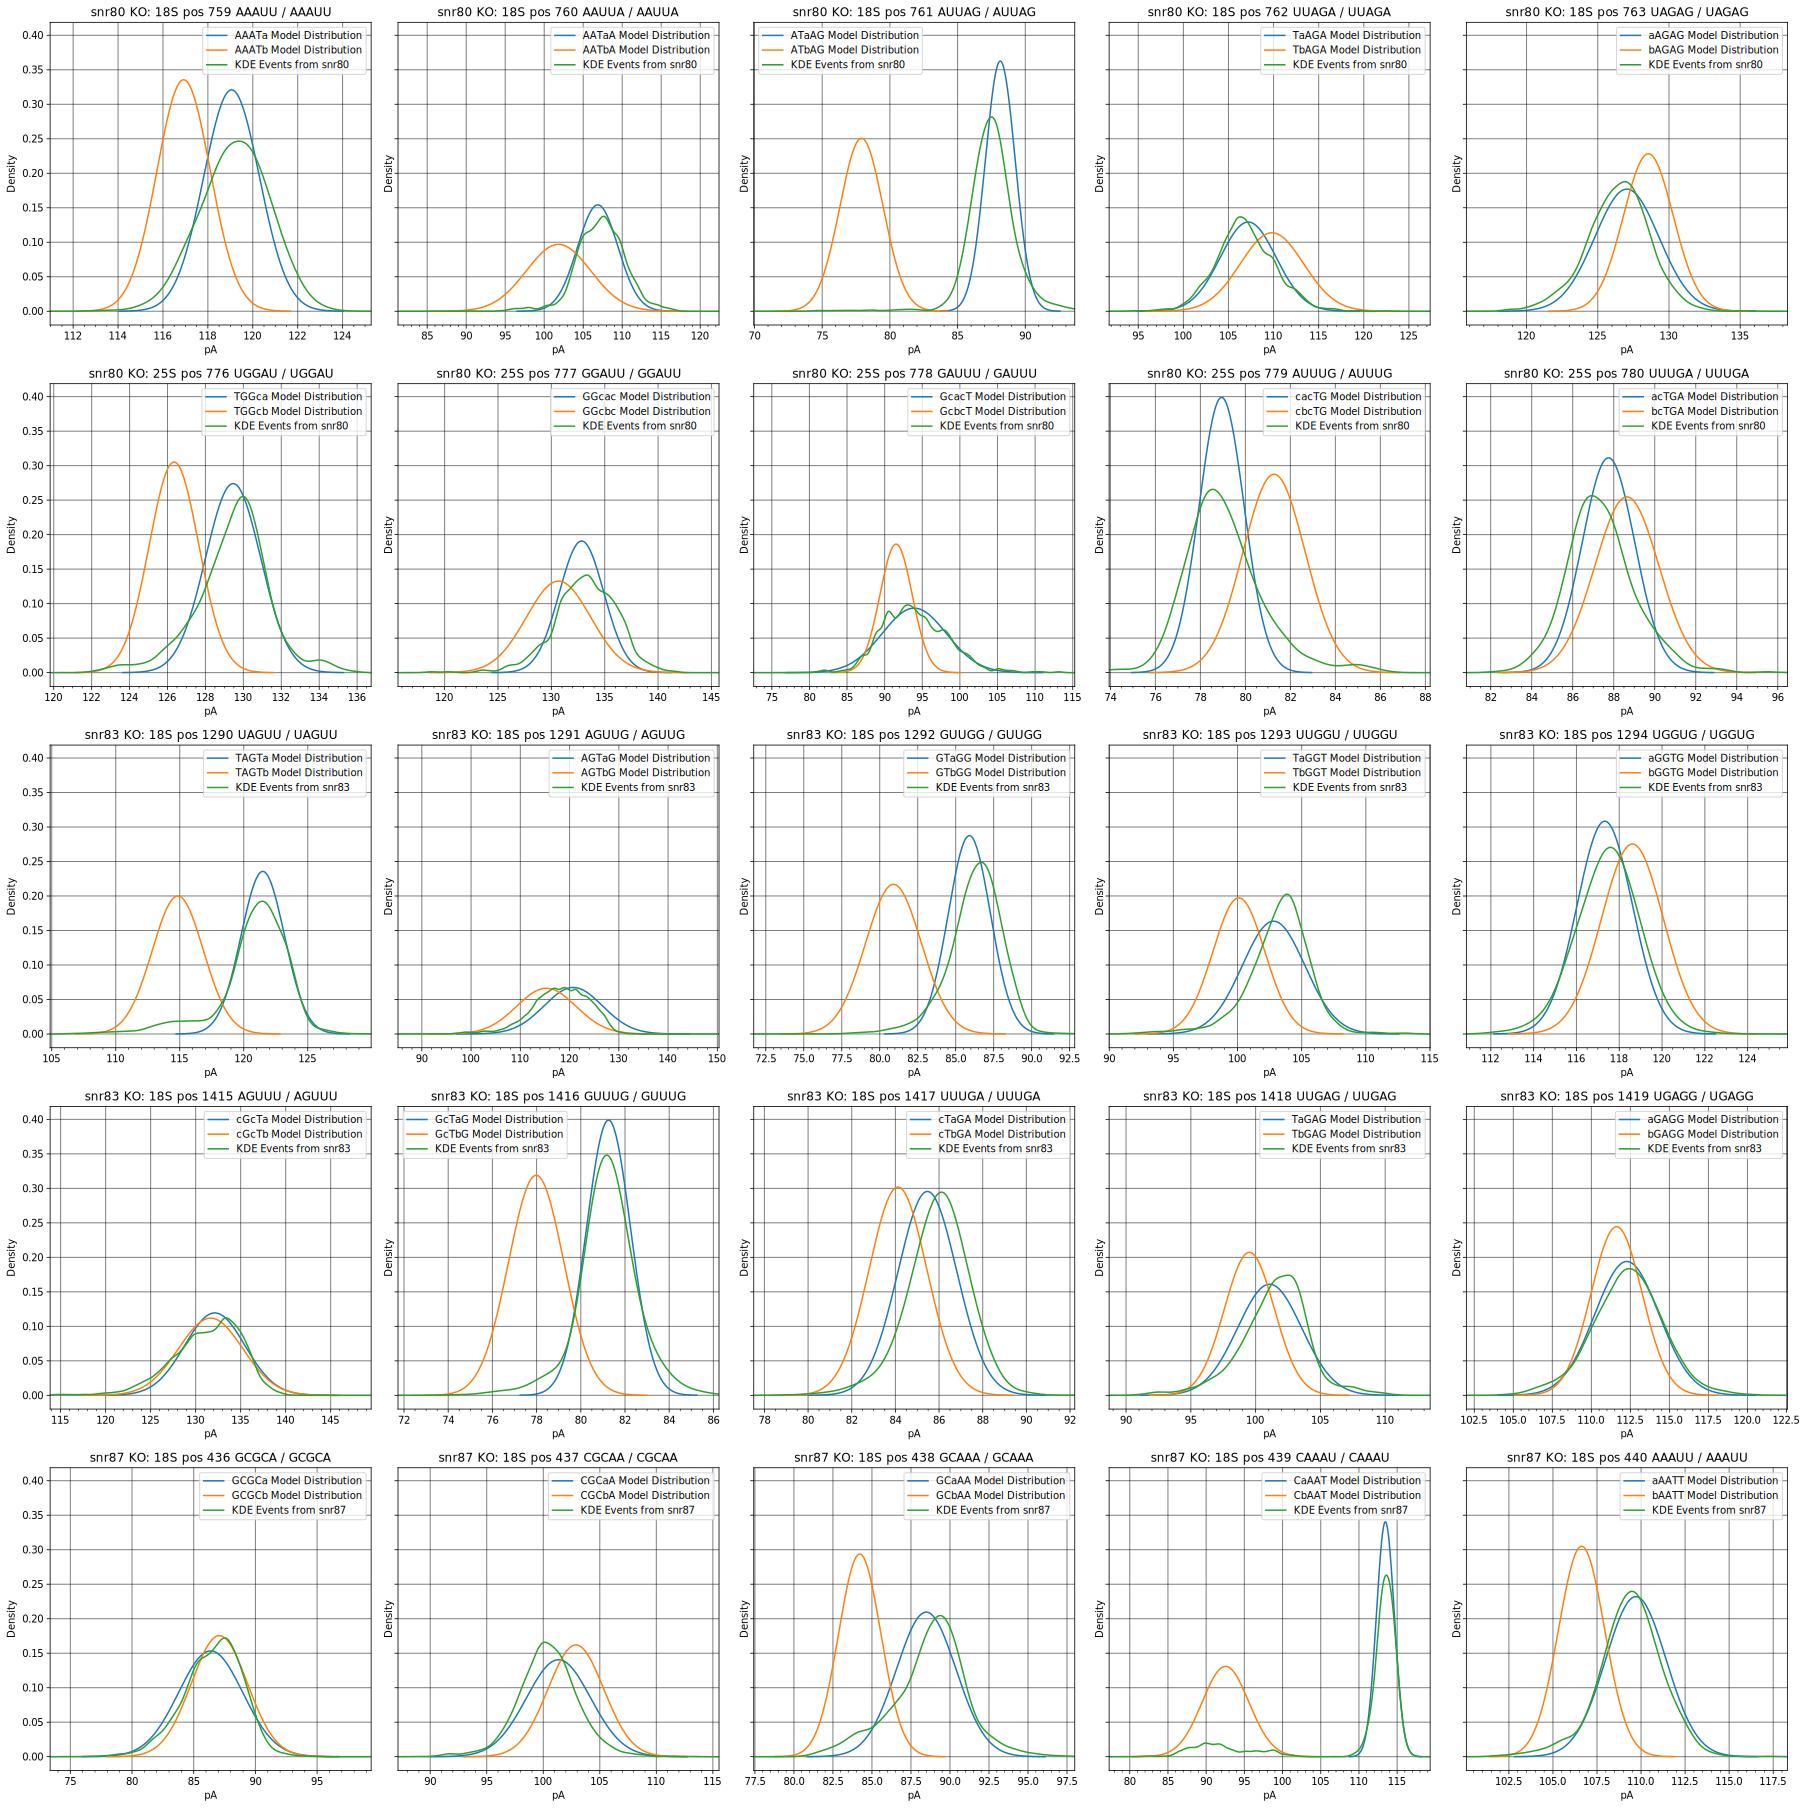

In [17]:
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

# fig = plt.figure(figsize=(100, 100))
fig, axs = plt.subplots(5, 5, figsize=(25, 25), sharey=True, constrained_layout=True)
# fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

for i, (name, kmers, event_path, contig, pos) in enumerate(experiments):
    if "18" in contig:
        rrna = "18S"
    else:
        rrna = "25S"
    seq = rh.get_sequence(contig, pos-5, pos+4).replace("T", "U")
    for j, kmer in enumerate(kmers):
        title = f"{name} KO: {rrna} pos {pos+j} {seq[j:5+j]} / {seq[j:5+j]}"
        kmer_data = parse_alignment_file(event_path.format(kmer=kmer))
        kmer_data = kmer_data[kmer_data["prob"] > 0.5]
        plot_distributions(axs[i, j], model_handle, [kmer, kmer.replace("a", "b")], kmer_data, name, title, savefig_dir=None)
#     model_handle.plot_kmer_distributions([kmer, kmer.replace("a", "b")], alignment_file_data=kmer_data)
savefig_dir = os.path.join(output_dir)
pathlib.Path(savefig_dir).mkdir(parents=True, exist_ok=True) 

if savefig_dir:
    out_name = "snoRNA_knockout_distributions.svg"
    out_path = os.path.join(savefig_dir, out_name)
    plt.savefig(out_path)
else:
    plt.show()